In [66]:
import numpy as np
import time


class HMM():    
    '''
    HMM有三个参数，pi代表隐藏状态的先验概率，A代表隐藏状态转移概率矩阵，B为一个混淆矩阵又称发射矩阵，代表从给定隐藏状态下可观测状态的概率矩阵
    首先解决给定数据集训练这三个参数的问题，brown数据集都给定了标签，实现有监督学习即可，较为简单
    '''

    def __init__(self,args):
        '''
        接收一个元组的列表，每个元组有两个元素，第一个为可观测状态数据，第二个为隐藏状态数据
        pi的key为隐藏状态，value为先验概率
        '''
        self.start_time=time.time()
        self.data=args

        self.ob_para_list=[tuple[0] for tuple in self.data]
        self.ob_para=list(set(self.ob_para_list))

        self.train()
        #self.print_para()


    def train(self):
        '''
        calculate A and B
        '''
        A, B, Pi = {}, {}, {}    # Use dict for faster index
        for i,pair in enumerate(self.data[:-1]) :
            if pair[1] in A.keys() :
                if self.data[i+1][1] in A[pair[1]].keys() :
                    A[pair[1]][self.data[i+1][1]] += 1
                else :
                    A[pair[1]][self.data[i+1][1]] = 1
            else :
                A[pair[1]] = {}
                A[pair[1]][self.data[i-1][1]] = 1
        if self.data[-1][1] not in A.keys() :
            A[self.data[-1][1]] = {}
        self.hidden_para = list(A.keys())
        self.A = [ [ A[j].get(i, 0) for i in self.hidden_para ] for j in self.hidden_para ]
        
        for pair in self.data :
            if pair[1] in B.keys() :
                if pair[0] in B[pair[1]].keys() :
                    B[pair[1]][pair[0]] += 1
                else :
                    B[pair[1]][pair[0]] = 1
                # also update Pi
                Pi[pair[1]] += 1
            else :
                B[pair[1]] = {}
                B[pair[1]][pair[0]] = 1
                Pi[pair[1]] = 1
        self.B = [ [ B[j].get(i, 0) for i in self.ob_para ] for j in self.hidden_para ]
        self.times = [ Pi[i] for i in self.hidden_para ]
        
        self.pi = [i/len(self.data) for i in self.times]
        
        self.hidden_len=len(self.hidden_para)
        self.ob_len=len(self.ob_para)
        print('Hidden states:'+str(self.hidden_len))
        print('Observed states:'+str(self.ob_len))

        self.A = [[ele/self.times[i] for ele in self.A[i]] for i in range(self.hidden_len)]
        self.B = [[ele/self.times[i] for ele in self.B[i]] for i in range(self.hidden_len)]
        
        self.end_time=time.time()
        print('Current program cost '+str(self.end_time-self.start_time)+'s')

    def print_para(self):
        self.print_pi()
        self.print_A()
        self.print_B()
        print('Current program cost '+str(self.end_time-self.start_time)+'s')

    def output_to_viterbi(self):
        '''
        返回HMM五元组
        '''
        return self.pi, self.A, self.B, self.hidden_para, self.ob_para

In [42]:
def viterbi(Pi, A, B, hList, oList, stc) :
    '''
    the Viterbi algorithm
    Viterbi use dp to find the best path (chain) of HMM hidden variables
    '''
    # Pi is the priori matrix, A the transition matrix, B the confuse matrix
    # hList reveals all POS, while oList shows all observed words. stc the input sentence

    # Substitude input sentence
    try :
        stcInd = [ oList.index(s) for s in stc ]
    except ValueError :
        print("Unprecedented word encountered! Please train more!")
        return None
    # Confuse matrix B is H * O, where H is the number of hidden vars, i.e. number of POS
    N, T = len(B), len(stc)
    dp = [ [ 0 ] * N for i in range(T) ]
    # Fill 1st row with Pi
    for i in range(N) :
        dp[0][i] = Pi[i] * B[i][stcInd[0]]
    # Fill other rows by dp[t][i] = max([dp[t-1][j] for j in range(N)] * a[j][i] * b[i][o_t])
    # O(TN^2)
    for t in range(1,T) :
        for i in range(N) :
            dp[t][i] = max([ dp[t-1][j] * A[j][i] * B[i][stcInd[t]] for j in range(N) ])
    # Retrace the path
    pos = []
    pos.append(dp[-1].index(max(dp[-1])))    # Could be multiple maxima. Choose the first one
    for t in range(T-2, -1, -1) :
        step = [ dp[t][j] * A[j][pos[-1]] * B[pos[-1]][stcInd[t+1]] for j in range(N) ]
        pos.append(step.index(max(step)))
    # Substitude hidden chain
    pos = [ ( stc[i], hList[p] ) for i,p in enumerate(pos[::-1]) ]
    
    return pos

In [78]:
from nltk.corpus import brown

INPUT_SIZE = 1000000
dataSet = brown.tagged_words(tagset='universal')[:INPUT_SIZE]
dataSet = [ [d[0].lower(), d[1]] for d in dataSet ]
hmm = HMM(dataSet)

Hidden states:12
Observed states:46207
Current program cost 3.5676281452178955s


In [149]:
import nltk
from nltk.corpus import stopwords

sentence = 'I will record a video if he breaks the record.'

words = nltk.word_tokenize(sentence)
words = [ word.lower() for word in words ]

# stops = set(stopwords.words("english"))
# words = [ word for word in words if word not in stops ]
taggedWords = nltk.pos_tag(words, tagset='universal')

print('Splitted & screened words:\n', words)
pos = viterbi(*hmm.output_to_viterbi(), words)
print('Tagged:\n', pos)
print('NLTK tagged:\n', taggedWords)

Splitted & screened words:
 ['i', 'will', 'record', 'a', 'video', 'if', 'he', 'breaks', 'the', 'record', '.']
Tagged:
 [('i', 'PRON'), ('will', 'VERB'), ('record', 'VERB'), ('a', 'DET'), ('video', 'NOUN'), ('if', 'ADP'), ('he', 'PRON'), ('breaks', 'VERB'), ('the', 'DET'), ('record', 'NOUN'), ('.', '.')]
NLTK tagged:
 [('i', 'NOUN'), ('will', 'VERB'), ('record', 'VERB'), ('a', 'DET'), ('video', 'NOUN'), ('if', 'ADP'), ('he', 'PRON'), ('breaks', 'VERB'), ('the', 'DET'), ('record', 'NOUN'), ('.', '.')]


In [128]:
import time

def tagTrain(data) :
    hmm = HMM(data)
    paras = hmm.output_to_viterbi()
    return paras, hmm.end_time-hmm.start_time

def tagPredict(data, paras) :
    stc = [d[0] for d in data]
    tags = [d[1] for d in data]
    # Deal with unseen words
    oList = paras[4]
    seenIdx = [i for i in range(len(stc)) if stc[i] in oList]
    seenStc = [stc[i] for i in seenIdx]
    # Predict
    startTime = time.time()
    pos = viterbi(*paras, seenStc)
    endTime = time.time()
    predictTags = [d[1] for d in pos]
    # Compliment unseen words
    predictTags = [predictTags[seenIdx.index(i)] if i in seenIdx else 'UNKNOWN' for i in range(len(stc))]
    #print(predictTags, data)
    # Correction rate
    correctNum = sum([1 for tag,pre in zip(tags,predictTags) if tag == pre])
    return pos, endTime - startTime, correctNum/len(tags)

In [145]:
# How performance changes along increasing of dataset

import nltk
from nltk.corpus import brown
import numpy as np

def performance(inputSize) :
    INPUT_SIZE = inputSize
    TEST_SIZE = 1000
    CHUCK_SIZE = 100

    dataSet = brown.tagged_words(tagset='universal')[:1000000+TEST_SIZE]
    dataSet = [ [d[0].lower(), d[1]] for d in dataSet ]
    trainSet, testSet = dataSet[:INPUT_SIZE], dataSet[1000000:1000000+TEST_SIZE]

    paras, trainTime = tagTrain(trainSet)
    times, corrects = [], []
    for i in range(TEST_SIZE//CHUCK_SIZE) :
        pos, predictTime, correct = tagPredict(testSet[i*CHUCK_SIZE:(i+1)*CHUCK_SIZE], paras)
        times.append(predictTime)
        corrects.append(correct)
    return trainTime, sum(times), np.mean(corrects)

perfs = []
for inputSize in range(5,101,5) :
    perf = performance(inputSize * 10000)
    perfs.append(perf)

Hidden states:12
Observed states:8202
Current program cost 0.10037446022033691s
Hidden states:12
Observed states:13082
Current program cost 0.23454737663269043s
Hidden states:12
Observed states:16254
Current program cost 0.34133338928222656s
Hidden states:12
Observed states:20231
Current program cost 0.39045286178588867s
Hidden states:12
Observed states:22562
Current program cost 0.6013193130493164s
Hidden states:12
Observed states:25366
Current program cost 0.5516853332519531s
Hidden states:12
Observed states:27442
Current program cost 0.6374242305755615s
Hidden states:12
Observed states:29482
Current program cost 0.7406680583953857s
Hidden states:12
Observed states:31392
Current program cost 0.8581607341766357s
Hidden states:12
Observed states:33120
Current program cost 0.9707698822021484s
Hidden states:12
Observed states:34671
Current program cost 1.083510160446167s
Hidden states:12
Observed states:36466
Current program cost 1.116267442703247s
Hidden states:12
Observed states:37459


Text(0,0.5,'Accuracy')

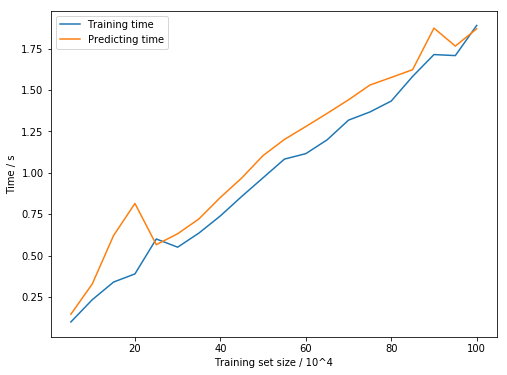

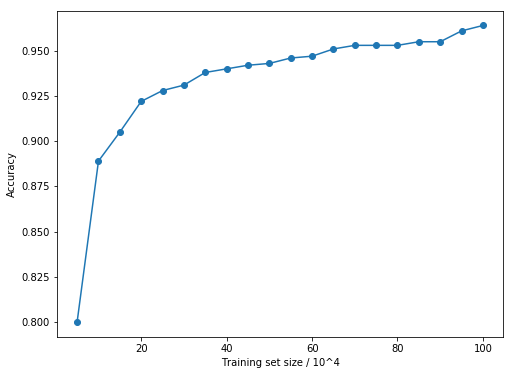

In [146]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(8,6))
for i in range(2) :
    plt.plot(range(5,101,5), [p[i] for p in perfs])
plt.legend(labels=['Training time', 'Predicting time'])
plt.xlabel('Training set size / 10^4')
plt.ylabel('Time / s')

plt.figure(figsize=(8,6))
plt.plot(range(5,101,5), [p[2] for p in perfs], marker='o')
plt.xlabel('Training set size / 10^4')
plt.ylabel('Accuracy')